In [1]:
# Enable autoreload extension
%load_ext autoreload
# Automatically reload all modules (except built-ins) before executing code
%autoreload 2

# Necessary

- Create VE
- Create dataset

In [2]:
import sys
import os
sys.path.append(os.path.abspath("/home/gdallagl/myworkdir/ESMSec/utils"))  # Adds current folder to Python path

import utils.my_functions as mf
import utils.models as my_models
import utils.dataset as my_dataset
import utils.embeddings_functions as my_embs
import utils.scanning as my_scanning

import torch
import torch.nn as nn
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from transformers import AutoModel, AutoTokenizer
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from tqdm import tqdm
import seaborn as sns

print(torch.__version__)

2.5.0+cu121


In [3]:
# Configuration / hyperparameters
config = {
    "SEED": 42,             # Random seed

    "NUM_EPOCHS": 200,       # Total Epochs in training
    "EVAL_EPOCH_FREQ": 10,   # Evaluation frequency
    "BATCH_SIZE": 64,       # Batch size
    "LR": 1e-4,             # Learning rate
    "LR_DECAY_GAMMA": 0.8,    # Learning rate decays
    "LR_DECAY_STEPS_EPOCHS": 50, # Learning rate decay steps
    "L2_REG": 0.01, # avoid to big weigths (imprve generalisation) (1 - weigths)

    "PROTEIN_MAX_LENGTH": 1000, # Max protein length (for ESM2)
    "PRETRAIN_ESM_CHECKPOINT_NAME": "facebook/esm2_t30_150M_UR50D",#"facebook/esm2_t33_650M_UR50D", #"facebook/esm2_t12_35M_UR50D", #"facebook/esm2_t6_8M_UR50D", # ESM2 model name --> if nto isntalled, autocally dowlaoded
    "PRETRAIN_ESM_CACHE_DIR": "/home/gdallagl/myworkdir/data/esm2-models", # ESM2 model cache dir
    "DEVICE": "cuda" if torch.cuda.is_available() else "cpu", # Device to use (cuda or cpu)

    "DATASET_PATH": "/home/gdallagl/myworkdir/ESMSec/data/cell_cycle/datasets/cc_dataset_final.csv", #"/home/gdallagl/myworkdir/ESMSec/data/secreted/dataset_lysoVSsecreted.csv", #'/home/gdallagl/myworkdir/ESMSec/data/cell_cycle/datasets/cc_dataset_final.csv', #"/home/gdallagl/myworkdir/ESMSec/data/cell_cycle/datasets/nucleolus_final_dataset.csv", #"/home/gdallagl/myworkdir/ESMSec/data/cell_cycle/cell-cycle-dataset_2:3.csv",  #"/home/gdallagl/myworkdir/ESMSec/data/cell_cycle/only-guaranteed_cell-cycle-dataset_2:3.csv", #"/home/gdallagl/myworkdir/ESMSec/data/cell_cycle/cell-cycle-dataset_2:3.csv", 
    "PATH_TO_SAVE_MODEL": "/home/gdallagl/myworkdir/ESMSec/data/trained_models/cell_cycle_trained_model.pth", # Path to save the model
    
    "TYPE_HEAD":"MLP",# "attention", #"MLP", "LR", gating_transformer
    "TYPE_EMB_FOR_CLASSIFICATION": "cls", #"concat(agg_mean, agg_max)", #"contextualized_embs", #"concat(agg_mean, agg_max)",cls, stacked_linearized_all
    "FROM_PRECOMPUTED_EMBS": True,
    "FORCE_RECOMPUTE_PRECOMPUTED_EMBS": True,
}
config["PRECOMPUTED_EMBS_PATH"] = os.path.join(
    f"/home/gdallagl/myworkdir/ESMSec/data/cell_cycle/precomputed_embs",
    f"{os.path.basename(config['DATASET_PATH']).split('.')[0]}_embs_"
    f"{config['PRETRAIN_ESM_CHECKPOINT_NAME'].replace('/', '-')}_"
    f"{config['TYPE_EMB_FOR_CLASSIFICATION']}.pt"
)

# Initializations
random.seed(config["SEED"])
np.random.seed(config["SEED"])
torch.manual_seed(config["SEED"])
torch.backends.cudnn.benchmark = True 

# Instantiate ESM model

In [4]:
# Load pre-trained ESM model
esm_model = AutoModel.from_pretrained(config["PRETRAIN_ESM_CHECKPOINT_NAME"],  cache_dir=config["PRETRAIN_ESM_CACHE_DIR"]).to(config["DEVICE"])
# Checj whcih model has been moded by AutoModel.from_pretrained()
print("\nESM model type", type(esm_model), "\n")

# Load relative tokenizer
tokenizer = AutoTokenizer.from_pretrained(config["PRETRAIN_ESM_CHECKPOINT_NAME"])

Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t30_150M_UR50D and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



ESM model type <class 'transformers.models.esm.modeling_esm.EsmModel'> 



# Load dataset and Tokenize

In [5]:
data = pd.read_csv(config["DATASET_PATH"])

num_samples = data.shape[0]

# ATTENTION:trucnat seqq to enforce max conetxt of EMS
data["truncated_sequence"] = data.sequence.apply(my_dataset.truncate_sequence)

# tokenize truncated seqeunces
    # ATTENTION: they a
print("Tokenizing...")
encoded = tokenizer(
    list(data.truncated_sequence),
    padding='max_length',
    max_length=config["PROTEIN_MAX_LENGTH"],
    truncation=True,
    return_tensors="pt"
)
# add to dict
input_ids_tensor = encoded["input_ids"]          # shape: (N, L)
attention_mask_tensor = encoded["attention_mask"]
# add to df
data["input_ids"] = [tensor for tensor in encoded["input_ids"]]
data["attention_mask"] = [tensor for tensor in encoded["attention_mask"]]

#####################

# save all information needed to tothe model
cache_data = {
    'protein': list(data.protein),
    'label': torch.tensor(data.label.values),
    'set': list(data.set),
    'sequence': list(data.sequence),
    'truncated_sequence': list(data.truncated_sequence),
    'input_ids': input_ids_tensor,
    'attention_mask': attention_mask_tensor,
    'embedding': torch.zeros((num_samples, 1), dtype=torch.float32) # FAKE
}


Tokenizing...


# Add or Create embs

Only if "from_precomputed_embs" is True

In [6]:
# add or use precomputed embs only if needed
if config["FROM_PRECOMPUTED_EMBS"]:

    if (not os.path.exists(config["PRECOMPUTED_EMBS_PATH"])) or (config["FORCE_RECOMPUTE_PRECOMPUTED_EMBS"]):
        print("Embeddings file not found. Calculating embs...")
        
        esm_model.eval()

        # Create dataloader for batched processing
        batch_size = config.get("BATCH_SIZE", 32)
        dataloader = my_dataset.create_dataloader(
            cache_data,
            batch_size=batch_size,
            shuffle=False
        )

        embeddings_list = []
        protein_names = []

        for batch in tqdm(dataloader, desc="Processing protein batches"):
            batch_input_ids = batch["input_ids"].to(config["DEVICE"])
            batch_attention_mask = batch["attention_mask"].to(config["DEVICE"])
            batch_proteins = batch["name"]

            with torch.no_grad():
                outputs_esm = esm_model(
                    input_ids=batch_input_ids, 
                    attention_mask=batch_attention_mask, 
                    return_dict=True
                )

                batch_embeddings = my_models.get_embs_from_context_embs( 
                                                            context_embs_esm = outputs_esm.last_hidden_state,
                                                            attention_mask = batch_attention_mask,
                                                            type_embs = config["TYPE_EMB_FOR_CLASSIFICATION"],
                                                            exclude_cls=True)

                # Store batch results
                protein_names.extend(batch_proteins)
                embeddings_list.append(batch_embeddings.detach().cpu())

        print("Saving embeddings to fast PyTorch cache...")
        torch.save({
            "protein": protein_names,
            "embedding": [e.cpu() for e in embeddings_list]  # list of tensors
        }, config["PRECOMPUTED_EMBS_PATH"])

        # # Concatenate all batch embeddings
        # all_embeddings = torch.cat(embeddings_list, dim=0)
        # emb_dict = {
        #     'protein': protein_names,
        #     'embedding': all_embeddings
        # }
        # torch.save(emb_dict, config["PRECOMPUTED_EMBS_PATH"])

    print(f"Reading back from file: {config['PRECOMPUTED_EMBS_PATH']}...")
    emb_dict = torch.load(config["PRECOMPUTED_EMBS_PATH"], weights_only=False)
    cache_data["embedding"] = torch.cat(emb_dict["embedding"], dim=0) #emb_dict["embedding"]

else:
    print("No precomputed embs")

Embeddings file not found. Calculating embs...


Processing protein batches:   0%|          | 0/19 [00:00<?, ?it/s]

Processing protein batches: 100%|██████████| 19/19 [02:42<00:00,  8.57s/it]

Saving embeddings to fast PyTorch cache...
Reading back from file: /home/gdallagl/myworkdir/ESMSec/data/cell_cycle/precomputed_embs/cc_dataset_final_embs_facebook-esm2_t30_150M_UR50D_cls.pt...


In [7]:
# Degfine classifcatio head dimesion

if config["FROM_PRECOMPUTED_EMBS"]:
    first_emb_shape = cache_data["embedding"].shape  # (N, L, D)
    if len(first_emb_shape) == 1:
        # Aggregated embedding (e.g., [D])
        config["PRECOMPUTED_EMBS_DIM"] = int(first_emb_shape[0])
    elif len(first_emb_shape) == 2:
        # Aggregated per sequence (e.g., [L, D])
        config["PRECOMPUTED_EMBS_DIM"] = int(first_emb_shape[1])
    elif len(first_emb_shape) == 3:
        # Contextualized embeddings (N, L, D) → use D
        config["PRECOMPUTED_EMBS_DIM"] = int(first_emb_shape[2])
else:
    # dim embessign sins the output of esm
    config["PRECOMPUTED_EMBS_DIM"] = esm_model.embeddings.word_embeddings.embedding_dim
    #fake embs
    cache_data["embedding"] = torch.zeros((num_samples, 1), dtype=torch.float32)

print(config["PRECOMPUTED_EMBS_DIM"])

640


Original: 3256, Truncated: 1000, Tokenized (no pad): 1000
Original: 339, Truncated: 339, Tokenized (no pad): 341
Original: 339, Truncated: 339, Tokenized (no pad): 341


protein                  : list length 1176
label                    : Tensor shape (1176,)
set                      : list length 1176
sequence                 : list length 1176
truncated_sequence       : list length 1176
input_ids                : Tensor shape (1176, 1000)
attention_mask           : Tensor shape (1176, 1000)
embedding                : Tensor shape (1176, 640)


<Axes: >

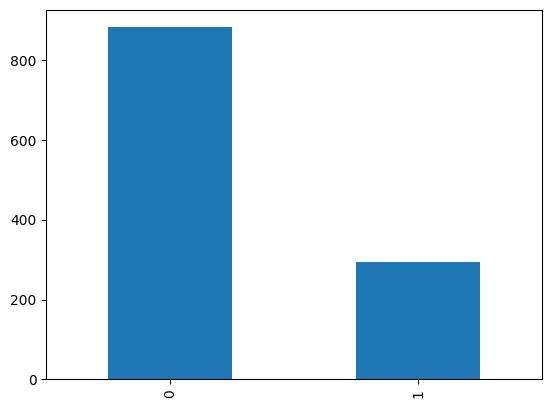

In [8]:
# Plotting

for i in range(3):
    seq = data.sequence.iloc[i]
    trunc_seq = data.truncated_sequence.iloc[i]
    input_ids = input_ids_tensor[i]
    print(f"Original: {len(seq)}, Truncated: {len(trunc_seq)}, Tokenized (no pad): {(input_ids != tokenizer.pad_token_id).sum().item()}")

print("\n")
for key, value in cache_data.items():
    if isinstance(value, torch.Tensor):
        print(f"{key:25s}: Tensor shape {tuple(value.shape)}")
    elif isinstance(value, pd.Series):
        print(f"{key:25s}: pandas Series, length {len(value)}")
    elif isinstance(value, (list, tuple)):
        print(f"{key:25s}: list length {len(value)}")
    else:
        print(f"{key:25s}: type {type(value)}")

data["label"].value_counts().reset_index(drop="True").plot(kind='bar')

# Create DataLoaders

In [9]:
# ATTENTION: the name of the cols in the df must be speicifc
train_indices = [i for i, s in enumerate(cache_data["set"]) if s == "train"] # select indices
train_cache_data = my_dataset.subset_data_dict(cache_data, train_indices) # create cache_data subset
train_dl = my_dataset.create_dataloader(train_cache_data, config["BATCH_SIZE"], shuffle=True) # create dataloader

valid_indices = [i for i, s in enumerate(cache_data["set"]) if s == "val"] 
valid_cache_data = my_dataset.subset_data_dict(cache_data, valid_indices) 
valid_dl = my_dataset.create_dataloader(valid_cache_data, config["BATCH_SIZE"], shuffle=True) 

test_indices = [i for i, s in enumerate(cache_data["set"]) if s == "test"] 
test_cache_data = my_dataset.subset_data_dict(cache_data, test_indices) 
test_dl = my_dataset.create_dataloader(test_cache_data, config["BATCH_SIZE"], shuffle=True) 



# little check:
batch = next(iter(train_dl))

input_ids = batch["input_ids"]
attention_mask = batch["attention_mask"]
labels = batch["label"]
names = batch["name"]
embs = batch["embs"]

print("=== Batch Information ===")
print(f"Batch size: {labels.shape[0]}\n")
print(f"Input IDs: Tensor, shape = {tuple(input_ids.shape)}, dtype = {input_ids.dtype}")
print(f"Attention mask: Tensor, shape = {tuple(attention_mask.shape)}, dtype = {attention_mask.dtype}")
print(f"Labels: Tensor, shape = {tuple(labels.shape)}, dtype = {labels.dtype}")
print(f"First 5 labels: {labels[:5]}")
print(f"Names: List, length = {len(names)}, first 5 = {names[:5]}")
print(f"Embeddings: Tensor, shape = {tuple(embs.shape)}, dtype = {embs.dtype}")


=== Batch Information ===
Batch size: 64

Input IDs: Tensor, shape = (64, 1000), dtype = torch.int64
Attention mask: Tensor, shape = (64, 1000), dtype = torch.int64
Labels: Tensor, shape = (64,), dtype = torch.int64
First 5 labels: tensor([0, 0, 1, 0, 0])
Names: List, length = 64, first 5 = ['P49770', 'Q99489', 'Q9BXW9', 'Q5VTL8', 'P62081']
Embeddings: Tensor, shape = (64, 640), dtype = torch.float32


# Instantiate Full model

In [10]:
# initialise model (ESM+ HEad)
net = my_models.EsmDeepSec(esm_model, 
                           type_head=config["TYPE_HEAD"],
                           type_emb_for_classification=config["TYPE_EMB_FOR_CLASSIFICATION"],
                           from_precomputed_embs=config["FROM_PRECOMPUTED_EMBS"],
                           precomputed_embs_dim=config["PRECOMPUTED_EMBS_DIM"]
                           ).to(config["DEVICE"])
# hidden dim of final embeggin of each aa after trnafoerm 
print(net.class_head)

# Block ESM paramters to be trained
if net.esm_model is not None:
    print("\nESM hidden dim", net.ESM_hidden_dim, "\n")
    for param in net.esm_model.parameters():
        param.requires_grad = False

MLPHead(
  (layer1): Sequential(
    (0): Linear(in_features=640, out_features=1280, bias=True)
    (1): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
  )
  (layer2): Sequential(
    (0): Linear(in_features=1280, out_features=628, bias=True)
    (1): LayerNorm((628,), eps=1e-05, elementwise_affine=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
  )
  (layer3): Sequential(
    (0): Linear(in_features=628, out_features=32, bias=True)
    (1): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
    (2): ReLU()
  )
  (classifier): Linear(in_features=32, out_features=2, bias=True)
)

ESM hidden dim 640 



# Define weighted loss fucntion

In [11]:
# Get class counts (ordered by label)
class_counts = data[data.set == "train"].label.value_counts().sort_index()
print("Class counts (ordered by label):", class_counts.to_dict())

# Convert counts to list [count_class_0, count_class_1]
class_counts_list = class_counts.tolist()

# Total number of samples
N = sum(class_counts_list)

# Compute class weights using w_i =  N / N_i
class_weights = torch.tensor([N / class_counts_list[0], N / class_counts_list[1]], dtype=torch.float)

# scale to avoid biased towrad class 1
#reduces bias toward class 1 while still giving minority class more importance.
class_weights = class_weights / class_weights.max()  # max weight = 1

# Move to device
class_weights = class_weights.to(config["DEVICE"])

# Print for sanity check
print(f"Class 0 count: {class_counts_list[0]}, weight: {class_weights[0]:.4f}")
print(f"Class 1 count: {class_counts_list[1]}, weight: {class_weights[1]:.4f}")

# Create loss function with class weights
loss_fn = nn.CrossEntropyLoss(weight=class_weights)

Class counts (ordered by label): {0: 705, 1: 236}
Class 0 count: 705, weight: 0.3348
Class 1 count: 236, weight: 1.0000


In [12]:

# Get class counts (ordered by label)
class_counts = data[data.set == "train"].label.value_counts().sort_index()
print("Class counts (ordered by label):", class_counts.to_dict())

# Convert counts to list [count_class_0, count_class_1]
class_counts_list = class_counts.tolist()
count_0 = class_counts_list[0]
count_1 = class_counts_list[1]

# Total number of samples
N = sum(class_counts_list)

# 1. Compute initial class weights (inverse frequency: N / N_i)
# This gives the minority class (let's assume class 1) a higher value
initial_weights = torch.tensor([N / count_0, N / count_1], dtype=torch.float)

# 2. Normalize the initial weights so they sum to 1
sum_of_weights = torch.sum(initial_weights)
class_weights = initial_weights / sum_of_weights

# Move to device
class_weights = class_weights.to(config["DEVICE"])

# Print for sanity check
print(f"Class 0 count: {count_0}, weight: {class_weights[0]:.4f}")
print(f"Class 1 count: {count_1}, weight: {class_weights[1]:.4f}")
print(f"Sum of weights: {class_weights.sum():.4f}") # Should be 1.0000

# Create loss function with class weights
loss_fn = nn.CrossEntropyLoss(weight=class_weights)

Class counts (ordered by label): {0: 705, 1: 236}
Class 0 count: 705, weight: 0.2508
Class 1 count: 236, weight: 0.7492
Sum of weights: 1.0000


# Train

In [ ]:
#results = mf.train(net, train_dl, valid_dl, test_dl, loss_fn, config)
results = mf.train(net, train_dl, valid_dl, test_dl, loss_fn, config, from_precomputed_embs=config["FROM_PRECOMPUTED_EMBS"]) # precomputed are in the dataloder

### Plot


                         FINAL EVALUATION METRICS
Metric                    Train      Validation            Test
--------------- --------------- --------------- ---------------
Loss                     0.0292          3.8604          0.7692
Accuracy                 99.26%           0.00%          82.91%
Balanced Acc             99.36%           0.00%          76.81%
F1 Score                 0.9853          0.0000          0.6491
MCC                      0.9804          0.0000          0.5361


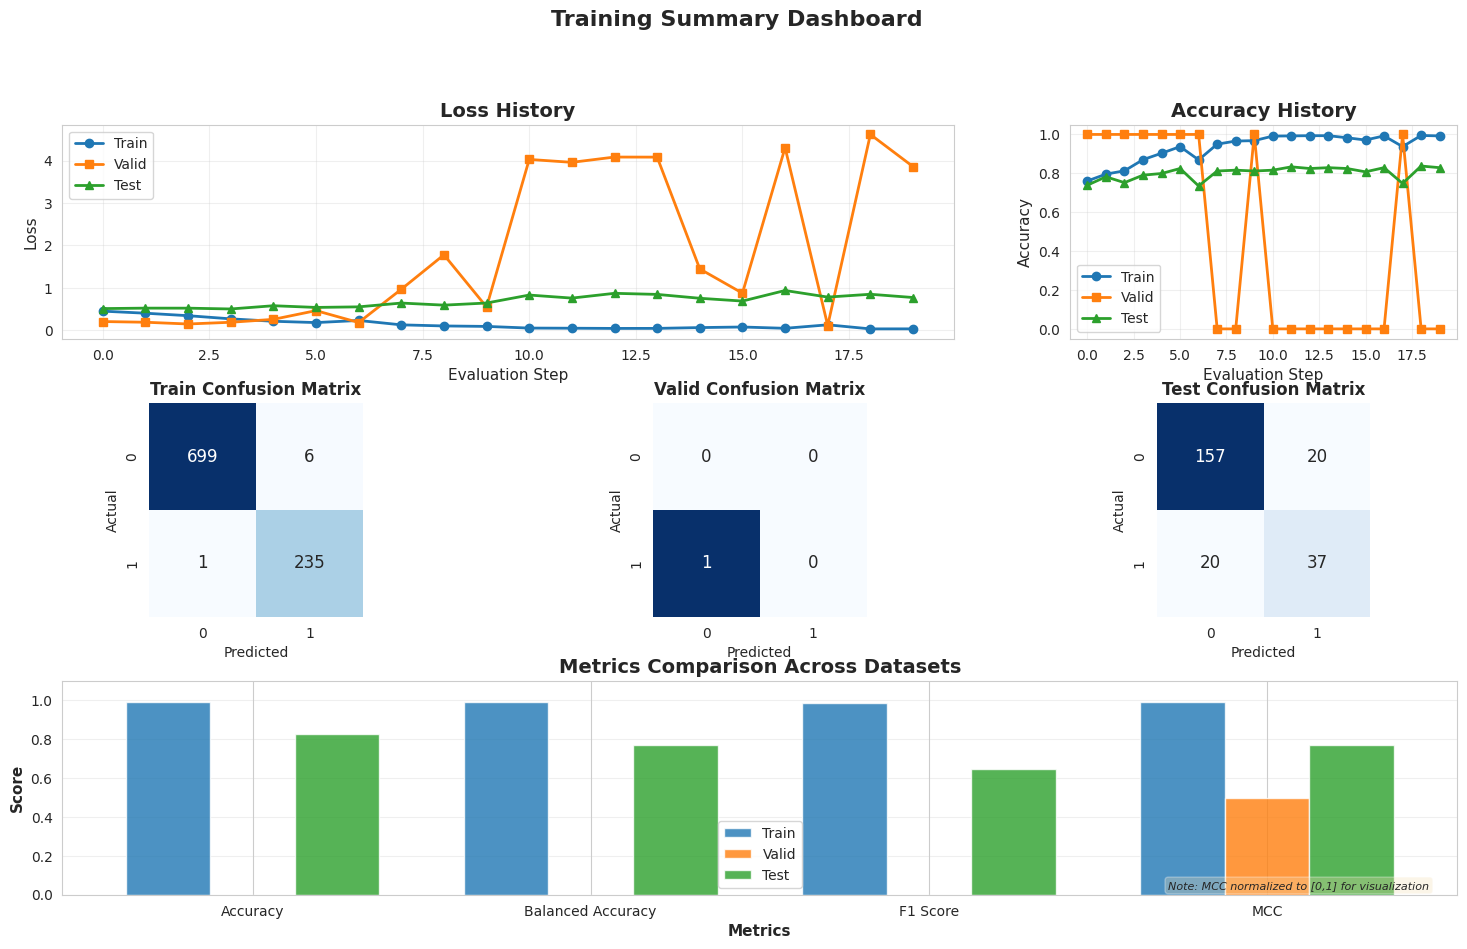


                         TEST SET CLASSIFICATION REPORT
              precision    recall  f1-score   support

     Class 0     0.8870    0.8870    0.8870       177
     Class 1     0.6491    0.6491    0.6491        57

    accuracy                         0.8291       234
   macro avg     0.7681    0.7681    0.7681       234
weighted avg     0.8291    0.8291    0.8291       234




In [14]:
mf.summarize_training(*results)

### Save Model

In [15]:
torch.save(net, config["PATH_TO_SAVE_MODEL"])

### Load Model

In [16]:
net = torch.load(config["PATH_TO_SAVE_MODEL"])
net.eval()

/tmp/ipykernel_196241/3766833804.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net = torch.load(config["PATH_TO_SAVE_MODEL"])


EsmDeepSec(
  (esm_model): EsmModel(
    (embeddings): EsmEmbeddings(
      (word_embeddings): Embedding(33, 640, padding_idx=1)
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): EsmEncoder(
      (layer): ModuleList(
        (0-29): 30 x EsmLayer(
          (attention): EsmAttention(
            (self): EsmSelfAttention(
              (query): Linear(in_features=640, out_features=640, bias=True)
              (key): Linear(in_features=640, out_features=640, bias=True)
              (value): Linear(in_features=640, out_features=640, bias=True)
              (rotary_embeddings): RotaryEmbedding()
            )
            (output): EsmSelfOutput(
              (dense): Linear(in_features=640, out_features=640, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (LayerNorm): LayerNorm((640,), eps=1e-05, elementwise_affine=True)
          )
          (intermediate): EsmIntermediate(
            (dense): Linear(in_features=640, out_

### Umaps

Many types of embeddings can be extracted from different moments inside the model:

**1. From the ESM backbone**
- **ESM mean** → mean pooling over all token embeddings.  
- **ESM max** → max pooling over all token embeddings.  
- **ESM CLS** → embedding of the special classification token (first position).  
- **ESM tokens** → full sequence of token-level embeddings `[batch, seq_len, hidden_dim]`.  
- (Optional) **Layerwise embeddings** → extracting hidden states from multiple layers (e.g. last 4).

**2. From the feature head (AttentionClassificationHead)**
- **Feature mean** → mean pooling after attention + FFNN.  
- **Feature max** → max pooling after attention + FFNN.  
- **Feature CLS** → CLS token representation after attention + FFNN.  
- **Feature concat** → concatenation of mean and max pooling (used for classification).  


Extracting embeddings from training set...



Batch:   0%|          | 0/15 [00:00<?, ? batch/s]

All possbile embedding given current model architecrure:
class_head_embs_mlp_layer3: (941, 32)
precomputed_embs: (941, 640)

Computing UMAP embeddings...

Computing UMAP for class_head_embs_mlp_layer3 with shape (941, 32)...
Computing UMAP for precomputed_embs with shape (941, 640)...

Plotting UMAP embeddings...



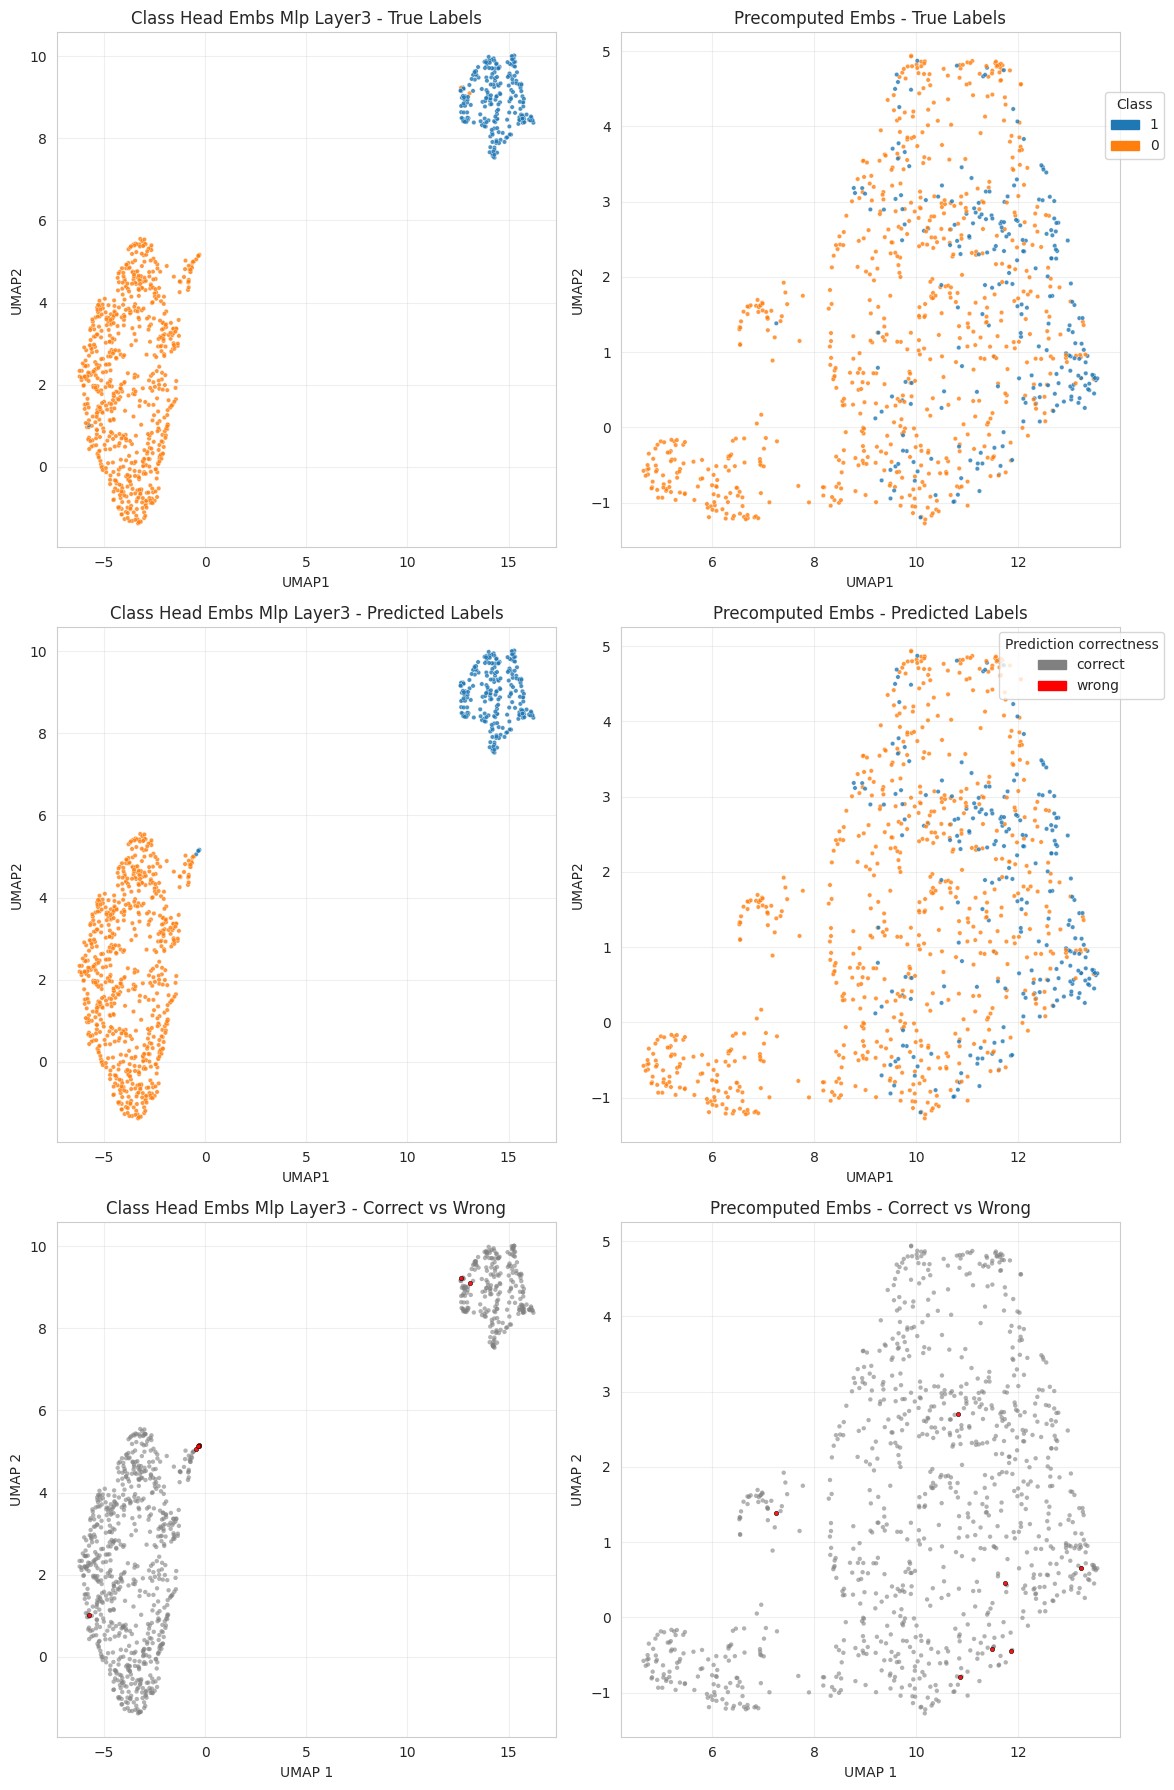

In [17]:
DATALOADER = train_dl

#############################
###### EXTRACT EMBEDDINGS
#############################

print("\nExtracting embeddings from training set...\n")

# Extract embeddings
train_embeddings, names, labels, predictions = my_embs.extract_embeddings(
    net=net,
    dl=DATALOADER,
    device=config["DEVICE"],
    return_numpy=True, # set to False if you want torch tensors instead
    from_precomputed_embs=config["FROM_PRECOMPUTED_EMBS"]
)

print("All possbile embedding given current model architecrure:")
# Example: check shapes
for key, emb in train_embeddings.items():
    if (emb is not None):
        print(f"{key}: {emb.shape}")

# for key, emb in train_embeddings.items():
#     if emb is not None:
#         print(f"\n{key}:")
#         print(f"  Type: {type(emb)}")
#         print(f"  Shape: {emb.shape}")
#         print(f"  Dtype: {emb.dtype}")
#         print(f"  Contains NaN: {np.isnan(emb).any()}")
#         print(f"  Contains Inf: {np.isinf(emb).any()}")
#         print(f"  Min: {np.nanmin(emb) if emb.size > 0 else 'empty'}")
#         print(f"  Max: {np.nanmax(emb) if emb.size > 0 else 'empty'}")
#         print(f"  All NaN: {np.isnan(emb).all()}")
#     else:
#         print(f"\n{key}: None")

#############################
###### CALCULATE UMAP
#############################

print("\nComputing UMAP embeddings...\n")

umap_tensors = my_embs.compute_umap_tensors( #dict of tensors
    embeddings_dict=train_embeddings,
)

#############################
###### PLOT
#############################

print("\nPlotting UMAP embeddings...\n")

if len(list(train_embeddings)) != 0:
    df = my_embs.plot_umap_embeddings(umap_tensors, names, labels, predictions, point_size=10)
else:
    print("No embs to plot")

In [18]:
df_precomputed = df["precomputed_embs"].copy()
#df_precomputed = df["class_head_embs_mlp_layer3"].copy()

Clustering complete. Added 'Cluster_Label' column to the DataFrame.
     Name      UMAP1     UMAP2 TrueClass PredClass CorrectStr  Cluster_Label
0  O43734  10.623624 -0.452653         0         0    correct              2
1  Q0P641   9.834063  4.795960         0         0    correct              0
2  Q14209  10.026869 -0.585808         1         1    correct              2
3  Q2TAA8  12.304360  0.570266         0         0    correct              3
4  Q9H9G7  12.370993  2.929558         0         0    correct              3


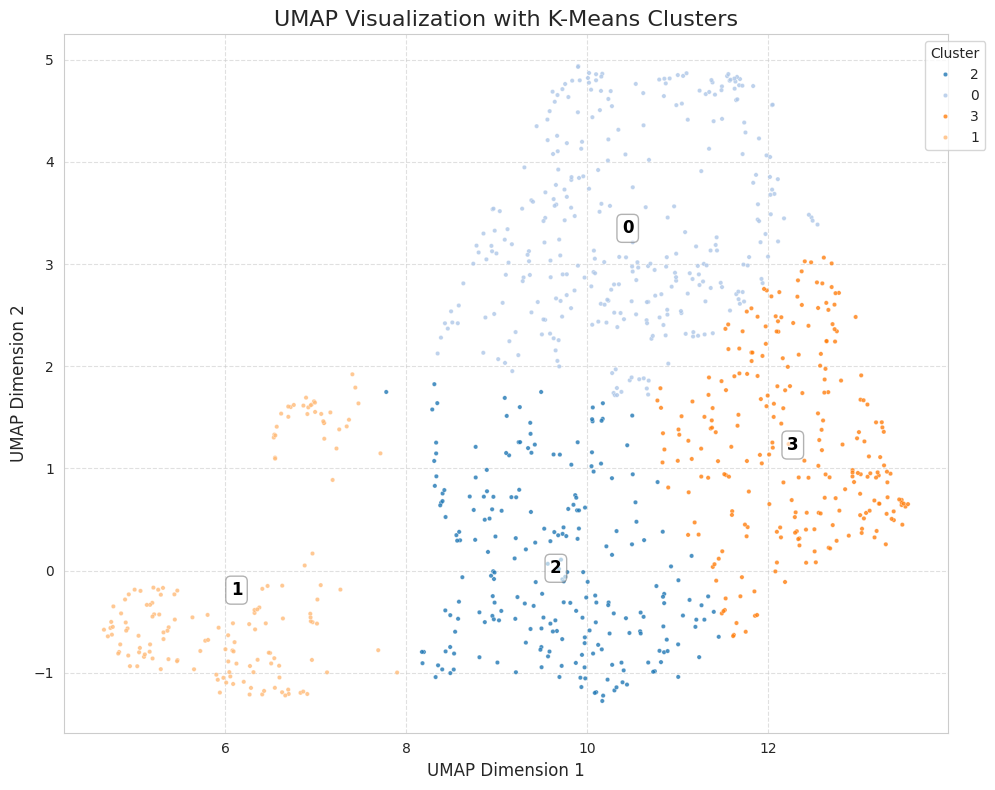

In [19]:
from sklearn.cluster import KMeans

# Define the features for clustering (the UMAP coordinates)
X_for_clustering = df_precomputed[['UMAP1', 'UMAP2']]

# Define the number of clusters (you should optimize this, e.g., using the Elbow Method)
K = 4

# Initialize and fit the K-Means model
kmeans = KMeans(n_clusters=K, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X_for_clustering)

# Save the cluster labels back to the DataFrame
df_precomputed['Cluster_Label'] = cluster_labels
print(f"Clustering complete. Added 'Cluster_Label' column to the DataFrame.")
print(df_precomputed.head())

my_embs.plot_umap_clusters(df_precomputed, point_size=10)

In [20]:
print(df_precomputed[df_precomputed.Cluster_Label == 1].Name.to_list()) 
print(df_precomputed[df_precomputed.Cluster_Label == 3].Name.to_list()) 

['P27169', 'Q9BUN1', 'Q7Z7N9', 'A0A1B0GTW7', 'Q19T08', 'O43280', 'O14548', 'O14832', 'Q8WUR7', 'Q96KW9', 'O43921', 'Q9Y2B2', 'Q9BPW8', 'P10109', 'O95866', 'Q86XE5', 'P02652', 'P05060', 'Q9HB07', 'Q96S96', 'Q8IUH2', 'Q9Y5U5', 'Q5T440', 'Q8N9H9', 'C9JH25', 'O43716', 'Q96L11', 'Q13084', 'Q6UB35', 'P20783', 'Q6UXB2', 'Q6IN84', 'Q9UJH8', 'Q9NQ60', 'P20061', 'P04279', 'Q08648', 'P30990', 'Q9BRJ2', 'Q9ULC0', 'P00797', 'Q86UD1', 'Q92935', 'Q13510', 'Q9Y2G5', 'Q6UWP8', 'P08842', 'P55145', 'P08582', 'Q13145', 'Q9UMS0', 'P05814', 'Q96GW9', 'P01160', 'P20396', 'O43674', 'Q96A98', 'Q9BYD2', 'P20800', 'P81605', 'Q9H741', 'P02768', 'Q9UIG4', 'Q8IW45', 'P02766', 'P19634', 'O00292', 'Q86WC4', 'Q9NQ76', 'Q92611', 'O75594', 'Q96QR1', 'P33316', 'P52961', 'Q6P5S2', 'P60507', 'Q9BQI4', 'Q9H5V8', 'P09912', 'Q6P1Q0', 'Q9HC23', 'Q68CP4', 'Q9NQ50', 'P20382', 'O75951', 'P04844', 'Q6UXH0', 'Q9NPC4', 'Q9HD89', 'Q8WXD2', 'P10124', 'Q8NBL1', 'O14657', 'P36222', 'P20674', 'P55056', 'P11117', 'A0A087X1C5', 'Q5T292', '

In [21]:
# wrong lablled
display(df_precomputed[(df_precomputed.CorrectStr == "correct") & (df_precomputed.TrueClass == "1")].head(5))

print("\nFalse postives")
FP_df = df_precomputed[(df_precomputed.TrueClass == "0") & (df_precomputed.PredClass == "1")]
print(FP_df.Name.to_list())
display(FP_df)

print("\nFalse Negatives")
FN_df = df_precomputed[(df_precomputed.TrueClass == "1") & (df_precomputed.PredClass == "0")]
print(FN_df.Name.to_list())
display(FN_df)

,Name,UMAP1,UMAP2,TrueClass,PredClass,CorrectStr,Cluster_Label
2,Q14209,10.026869,-0.585808,1,1,correct,2
11,Q15691,11.814949,2.567607,1,1,correct,3
13,P49321,11.421085,1.354672,1,1,correct,3
22,Q96QE3,13.176132,0.324845,1,1,correct,3
30,Q69YH5,13.199272,0.387858,1,1,correct,3



False postives
['Q5U623', 'Q8TBE0', 'Q5T7V8', 'P05114', 'O43299', 'Q14159']


,Name,UMAP1,UMAP2,TrueClass,PredClass,CorrectStr,Cluster_Label
18,Q5U623,13.224080,0.655700,0,1,wrong,3
88,Q8TBE0,10.849711,-0.799266,0,1,wrong,2
120,Q5T7V8,11.743698,0.450230,0,1,wrong,3
203,P05114,10.819627,2.705796,0,1,wrong,0
374,O43299,11.854821,-0.442535,0,1,wrong,3
498,Q14159,11.488168,-0.419038,0,1,wrong,3



False Negatives
['P33316']


,Name,UMAP1,UMAP2,TrueClass,PredClass,CorrectStr,Cluster_Label
484,P33316,7.258999,1.382098,1,0,wrong,1



Extracting embeddings from training set...



Batch:   0%|          | 0/4 [00:00<?, ? batch/s]

All possbile embedding given current model architecrure:
class_head_embs_mlp_layer3: (234, 32)
precomputed_embs: (234, 640)

Computing UMAP embeddings...

Computing UMAP for class_head_embs_mlp_layer3 with shape (234, 32)...


Computing UMAP for precomputed_embs with shape (234, 640)...

Plotting UMAP embeddings...



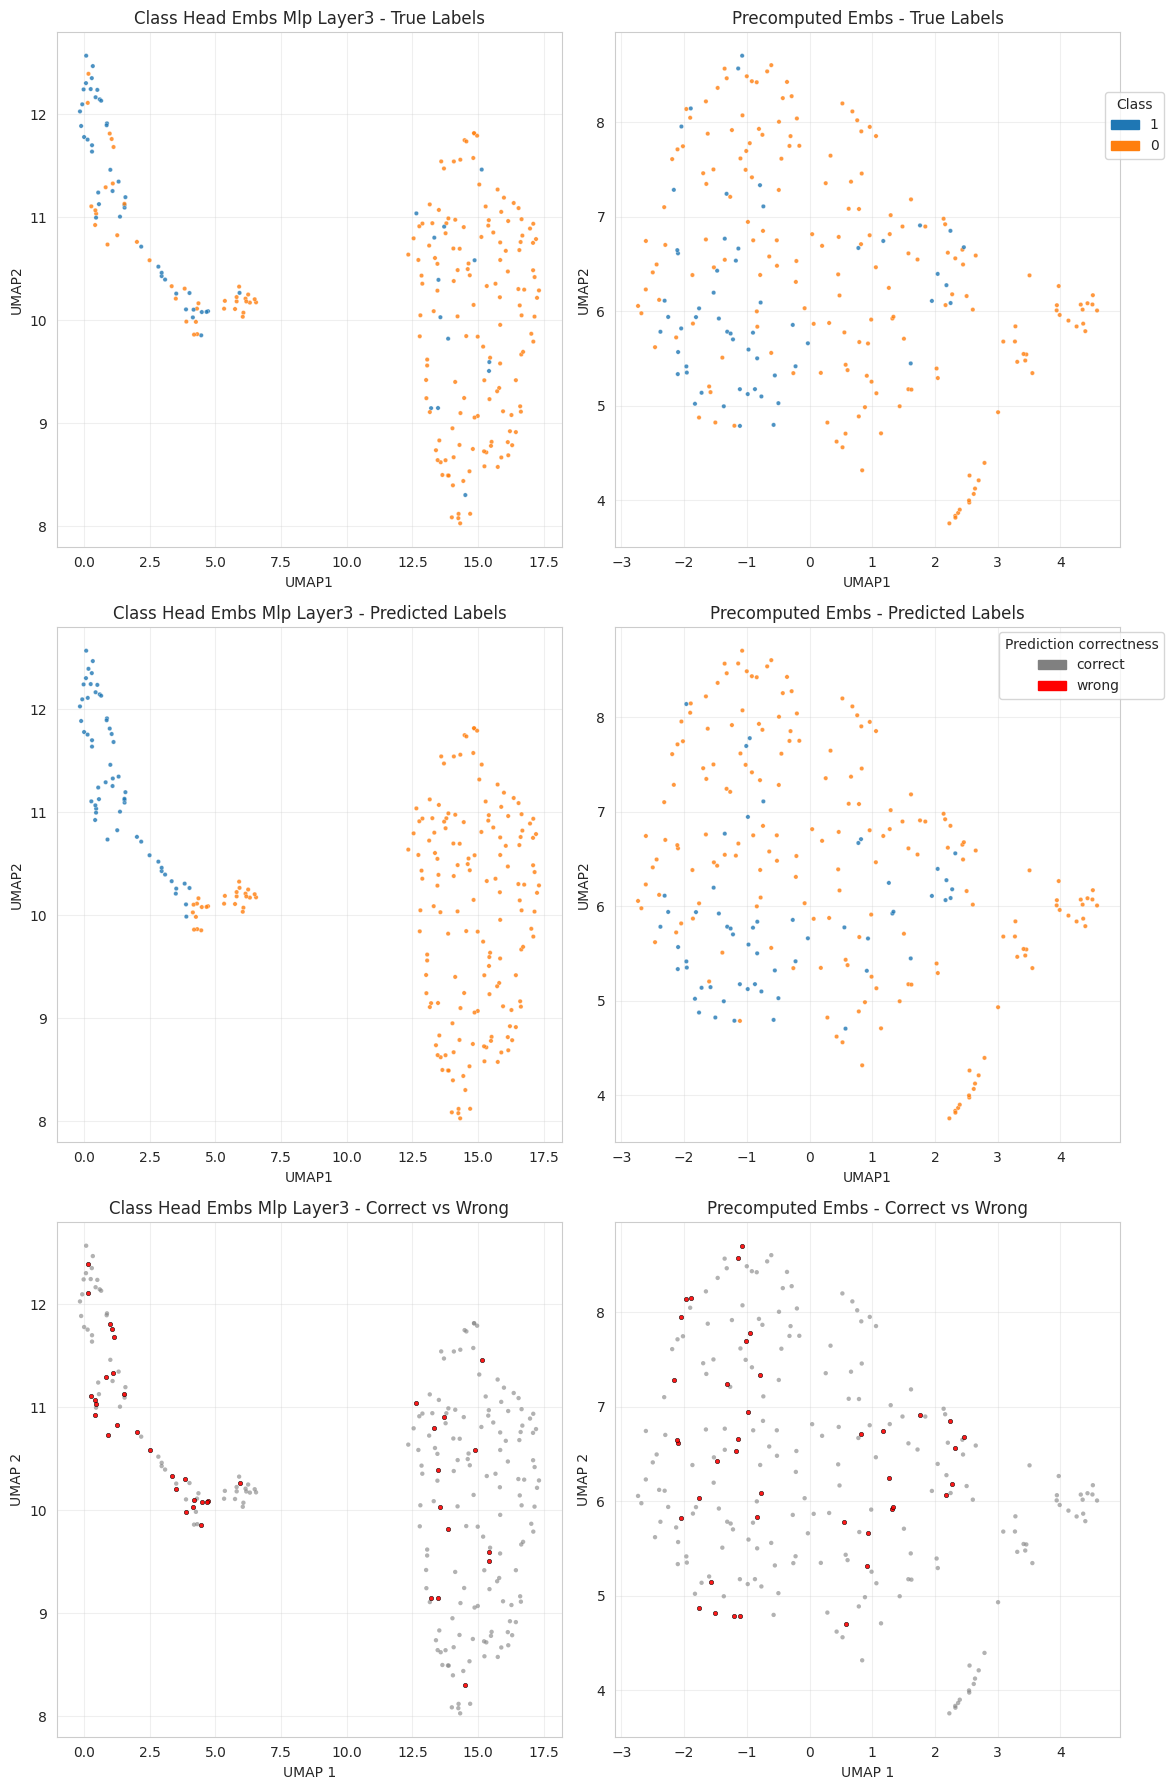

In [22]:
DATALOADER = test_dl

#############################
###### EXTRACT EMBEDDINGS
#############################

print("\nExtracting embeddings from training set...\n")

# Extract embeddings
train_embeddings, names, labels, predictions = my_embs.extract_embeddings(
    net=net,
    dl=DATALOADER,
    device=config["DEVICE"],
    return_numpy=True, # set to False if you want torch tensors instead
    from_precomputed_embs=config["FROM_PRECOMPUTED_EMBS"]
)

print("All possbile embedding given current model architecrure:")
# Example: check shapes
for key, emb in train_embeddings.items():
    if (emb is not None):
        print(f"{key}: {emb.shape}")

#############################
###### CALCULATE UMAP
#############################

print("\nComputing UMAP embeddings...\n")

umap_tensors = my_embs.compute_umap_tensors( #dict of tensors
    embeddings_dict=train_embeddings,
)

#############################
###### PLOT
#############################

print("\nPlotting UMAP embeddings...\n")

if len(list(train_embeddings)) != 0:
    df = my_embs.plot_umap_embeddings(umap_tensors, names, labels, predictions, point_size=10)
else:
    print("No embs to plot")

In [23]:
df_precomputed = df["precomputed_embs"].copy()
#df_precomputed = df["class_head_embs_mlp_layer3"].copy()

# wrong lablled
display(df_precomputed[(df_precomputed.CorrectStr == "correct")].head(5))

FP_df = df_precomputed[(df_precomputed.TrueClass == "0") & (df_precomputed.PredClass == "1")]
print(FP_df.Name.to_list())
display(FP_df)

print("\nFalse Negatives")
FN_df = df_precomputed[(df_precomputed.TrueClass == "1") & (df_precomputed.PredClass == "0")]
print(FN_df.Name.to_list())
display(FN_df)

,Name,UMAP1,UMAP2,TrueClass,PredClass,CorrectStr
0,Q5T6L9,-1.069019,8.071106,0,0,correct
1,P02545,-1.721521,5.135260,1,1,correct
2,P32969,-2.317839,7.099426,0,0,correct
4,Q86T03,0.989479,5.252410,0,0,correct
5,Q6P988,3.457945,5.541038,0,0,correct


['P0C7W6', 'Q4KMQ1', 'Q8IXW0', 'Q7Z6J8', 'P84090', 'Q8IYS8', 'Q96CW6', 'Q96QF7', 'Q15834', 'Q9BVM2', 'Q6ZMI0', 'Q8IZD4', 'O95983', 'Q6PH81', 'P07951', 'Q8N5C6', 'Q96G01', 'Q96AA8', 'A6NDB9', 'Q15527']


,Name,UMAP1,UMAP2,TrueClass,PredClass,CorrectStr
18,P0C7W6,-1.009147,7.693801,0,1,wrong
24,Q4KMQ1,2.275162,6.177709,0,1,wrong
25,Q8IXW0,2.324672,6.558066,0,1,wrong
45,Q7Z6J8,0.821377,6.707922,0,1,wrong
49,P84090,-1.964750,8.137968,0,1,wrong
69,Q8IYS8,0.574263,4.702933,0,1,wrong
80,Q96CW6,1.321923,5.920977,0,1,wrong
88,Q96QF7,-0.833092,5.834228,0,1,wrong
90,Q15834,2.169672,6.063128,0,1,wrong
91,Q9BVM2,0.932707,5.656839,0,1,wrong



False Negatives
['P31350', 'Q8TAT5', 'P33552', 'Q9Y248', 'Q9NRG9', 'Q16667', 'P04818', 'Q15468', 'Q9BS16', 'P35244', 'Q9UI95', 'O75531', 'Q12815', 'Q96EA4', 'Q14691', 'Q99640', 'P49642', 'Q9BRT9', 'Q9BQ89', 'P81274']


,Name,UMAP1,UMAP2,TrueClass,PredClass,CorrectStr
3,P31350,-1.473334,6.427126,1,0,wrong
6,Q8TAT5,-1.135192,6.661381,1,0,wrong
12,P33552,-1.893620,8.144242,1,0,wrong
17,Q9Y248,-2.097796,6.610812,1,0,wrong
56,Q9NRG9,1.176366,6.741574,1,0,wrong
70,Q16667,-1.322702,7.240517,1,0,wrong
81,P04818,-1.074485,8.701936,1,0,wrong
82,Q15468,-0.779158,6.090117,1,0,wrong
112,Q9BS16,-0.789918,7.332062,1,0,wrong
119,P35244,-2.164067,7.282660,1,0,wrong


# A-scanning

In [25]:
PROTEIN = "P02545" #df[(df["CorrectStr"] == "correct") & (df["TrueClass"] == "1")].iloc[0].Name
    # Q4QAE3
#"A0A8V8TKW5" #"P39039" # "Q91VU0"
WINDOW_SIZE_FRACTION = 0.01 # 10% of sequence length
SUBSTITUTE_AA = ["A", "R", "E", "F"] #"<pad>", "A", "P"
WINDOW_SIZE_SUBSTITUION = 5 #int(single_protein_info.trunc_sequence_length * WINDOW_SIZE_FRACTION // 2 * 2 + 1) # make it odd
print("window size: ", WINDOW_SIZE_SUBSTITUION)

##############################

net.from_precomputed_embs = False # need to recompute embs for each mutation
# ATTNETION: use SAME intial embs (embs passed to calssfricvation head) used IN TRAINING!!
net.type_emb_for_classification = config["TYPE_EMB_FOR_CLASSIFICATION"] 

##############################
# select single port data

idx = [cache_data["protein"].index(PROTEIN)] # encapslu in a lsit
selected_protein_data = my_dataset.subset_data_dict(cache_data, idx)
#print(selected_protein_data)

##############################
# calcualte baseline prob

baseline_prob = my_scanning.get_prob_single_protein(net, selected_protein_data, device="cuda")
print(baseline_prob)

##############################
# create all mutatios

all_mutated_seqs = my_scanning.create_all_mutations(selected_protein_data["truncated_sequence"][0], WINDOW_SIZE_SUBSTITUION, SUBSTITUTE_AA)
tot_mutations = len(all_mutated_seqs)
print(tot_mutations,  len(list(selected_protein_data["truncated_sequence"][0])) * len(SUBSTITUTE_AA))

# create dict
cache_mutations = {
    "protein": [selected_protein_data["protein"][0]] * tot_mutations,
    "label": torch.tensor([selected_protein_data["label"][0]] * tot_mutations),
    "set": [selected_protein_data["set"][0]] * tot_mutations,
    "sequence": all_mutated_seqs, 
    "truncated_sequence": all_mutated_seqs, 
}
# tokenize AS ABOVE (start ntoebook)
encoded = tokenizer(
    list(cache_mutations["truncated_sequence"]),
    padding='max_length',
    max_length=config["PROTEIN_MAX_LENGTH"],
    truncation=True,
    return_tensors="pt"
)
# add to dict
cache_mutations['input_ids'] =  encoded["input_ids"]  
cache_mutations[ 'attention_mask'] =  encoded["attention_mask"]
# ATTNETION: fake embs, as force to calculte here
cache_mutations["embedding"] = torch.zeros((tot_mutations, 1), dtype=torch.float32)



window size:  5


Evaluation:   0%|          | 0/1 [00:00<?, ? Single protein batch/s]

0.9872194528579712


Generating mutations:   0%|          | 0/664 [00:00<?, ?it/s]

2656 2656


In [26]:
scan_results = my_scanning.multi_aa_scanning_final(
    model=net,
    baseline_prob=baseline_prob,
    cache_mutations=cache_mutations,
    substitute_aas=SUBSTITUTE_AA,
    window_size=WINDOW_SIZE_SUBSTITUION,
    normalise_true_substitution=False,
    device="cuda", 
    batch_size=128
)

Evaluation:   0%|          | 0/21 [00:00<?, ? mutations batch/s]

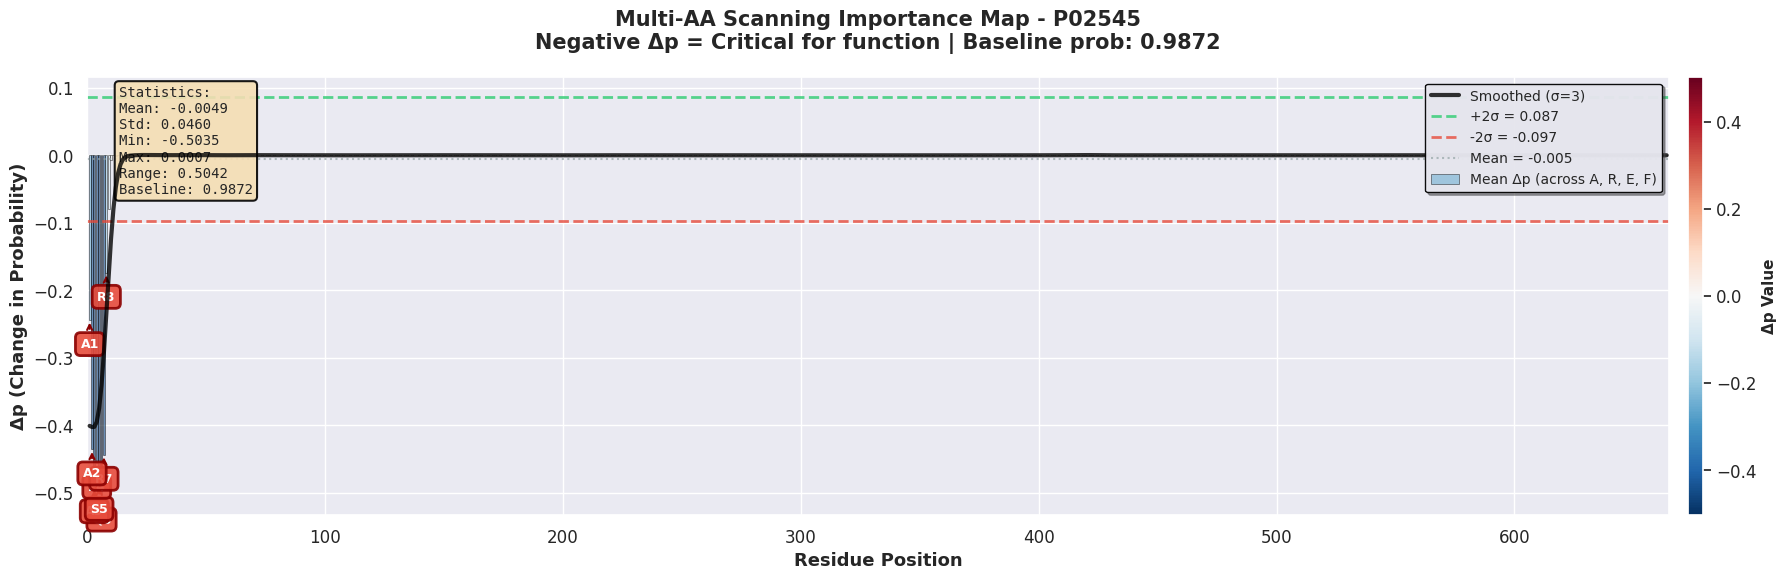


                      MULTI-AA SCANNING SUMMARY                       

Sequence Information:         
  Length:                   664
  Protein:                  P02545
  Substitute AAs:           A, R, E, F
  Baseline Probability:     0.9872

Statistical Summary:          
  Mean Δp:                  -0.0049
  Std Δp:                   0.0460
  Min Δp:                   -0.5035
  Max Δp:                   0.0007
  Threshold (+2σ):          0.0871
  Threshold (-2σ):          -0.0969

──────────────────────────────────────────────────────────────────────
             TOP CRITICAL RESIDUES (Largest Negative Δp)              
──────────────────────────────────────────────────────────────────────
Rank    Position    Residue     Δp             Status              
──────────────────────────────────────────────────────────────────────
1       6           Q           -0.5035        ⚠️  Beyond threshold
2       3           A           -0.4912        ⚠️  Beyond threshold
3       5           S

In [27]:
my_scanning.plot_multi_aa_scan(scan_results, show_per_aa=False)

In [ ]:
selected_protein_data

{'protein': ['P06280'],
 'label': tensor([1]),
 'set': ['train'],
 'sequence': ['MQLRNPELHLGCALALRFLALVSWDIPGARALDNGLARTPTMGWLHWERFMCNLDCQEEPDSCISEKLFMEMAELMVSEGWKDAGYEYLCIDDCWMAPQRDSEGRLQADPQRFPHGIRQLANYVHSKGLKLGIYADVGNKTCAGFPGSFGYYDIDAQTFADWGVDLLKFDGCYCDSLENLADGYKHMSLALNRTGRSIVYSCEWPLYMWPFQKPNYTEIRQYCNHWRNFADIDDSWKSIKSILDWTSFNQERIVDVAGPGGWNDPDMLVIGNFGLSWNQQVTQMALWAIMAAPLFMSNDLRHISPQAKALLQDKDVIAINQDPLGKQGYQLRQGDNFEVWERPLSGLAWAVAMINRQEIGGPRSYTIAVASLGKGVACNPACFITQLLPVKRKLGFYEWTSRLRSHINPTGTVLLQLENTMQMSLKDLL'],
 'truncated_sequence': ['MQLRNPELHLGCALALRFLALVSWDIPGARALDNGLARTPTMGWLHWERFMCNLDCQEEPDSCISEKLFMEMAELMVSEGWKDAGYEYLCIDDCWMAPQRDSEGRLQADPQRFPHGIRQLANYVHSKGLKLGIYADVGNKTCAGFPGSFGYYDIDAQTFADWGVDLLKFDGCYCDSLENLADGYKHMSLALNRTGRSIVYSCEWPLYMWPFQKPNYTEIRQYCNHWRNFADIDDSWKSIKSILDWTSFNQERIVDVAGPGGWNDPDMLVIGNFGLSWNQQVTQMALWAIMAAPLFMSNDLRHISPQAKALLQDKDVIAINQDPLGKQGYQLRQGDNFEVWERPLSGLAWAVAMINRQEIGGPRSYTIAVASLGKGVACNPACFITQLLPVKRKLGFYEWTSRLRSHINPTGTVLLQLENTMQMSLKDLL'],
 'input_ids': tensor([[ 0, 2

# AAAAAAAAAAAAAAAAAAAAAAAAAAAAAA
# AAAAAAAAAAAAAAAAAAAAAAAAAAAAAA

### A-scanning Logits

In [ ]:
def prob_to_logit(p):
    """
    Convert probability of class 1 to logit (binary case)
    p: float or np.array of probabilities (0 < p < 1)
    returns: logit value(s)
    """
    p = np.clip(p, 1e-15, 1 - 1e-15)  # avoid log(0)
    return np.log(p / (1 - p))


PROTEIN = "P05997" #"Q6ZRI0" #"P01270" #"O60938" #"P05997"
WINDOW_SIZE_FRACTION = 0.01 # 10% of sequence length
SUBSTITUTE_AA = "A" #"<pad>", "A", "P"

# Extract info
single_protein_info = data_df[data_df['protein'] == PROTEIN].iloc[0]
display(single_protein_info)

WINDOW_SIZE_SUBSTITUION = int(single_protein_info.trunc_sequence_length * WINDOW_SIZE_FRACTION // 2 * 2 + 1) # make it odd
print(WINDOW_SIZE_SUBSTITUION)

# Run alanine scanning
results = mf.alanine_scanning(
    model=net,
    tokenizer=tokenizer,
    single_protein_info=single_protein_info,
    window_size=WINDOW_SIZE_SUBSTITUION, # make it odd
    device=config["DEVICE"],
    SUBSTITUTE_AA=SUBSTITUTE_AA,
    normalise_true_substitution=True #normalise by number of true substitutions (not A->A
)

# calcuate logits
baseline_logit = prob_to_logit(results['baseline_prob'])
mutated_logits = prob_to_logit(results['mutated_probs'])
delta_logit = mutated_logits - baseline_logit

mf.plot_alanine_scan(
    delta_p=delta_logit,
    sequence=results['sequence'],
    protein_name=results['protein_name'],
    sigma=3,
    threshold=True,
    highlight_residues=True,
    top_n=10,
    show_sequence=False,
    style='whitegrid'  # Options: 'darkgrid', 'whitegrid', 'dark', 'white', 'ticks'
)

NameError: name 'data_df' is not defined

### Random prot

In [ ]:
random_prot = "MVMAAAKKNMQQLDSFKGDDSIDHEIATPYSWQRKFSGESKAIALGMYGTKMISCGQWRDQACYILYWVFWYPYFNVSQESIVLQYDLPHYGYDIFKPYINQTARCCPHHPQEAMNSEGNTVPACYAAVGQADPPIFDIAYSIMILRPLYGTCNPTGFQNVMNAIWSEEMAMFTQTHYVLPYRYPYQTYRLTSFSSRIMMENAGACEWESMVNFIFRTVAKRCKDKEYLFGNCAWTRLWSIAPHQWKWPSKNTHMYIDHFVEKGKQEELSNASWHTYLATSICPAHHHDWVWWNFEFWLCHFTEMDT"
random_label = 0
random_name = "Random_Prot"
random_data = pd.DataFrame([{
    'sequence': random_prot,
    'label': random_label,
    'protein': random_name,
    'set': 'test'
}])

# Preprocess each sequence individually
random_preprocessed_data = []
for idx, row in tqdm(random_data.iterrows(), total=len(random_data)):
    processed = my_dataset.preprocess_sequence(
        sequence=row['sequence'],
        label=row['label'],
        protein_name=row['protein'],
        tokenizer=tokenizer,
        protein_max_length=config["PROTEIN_MAX_LENGTH"]
    )
    random_preprocessed_data.append(processed)

# Create DataFrame from preprocessed data
random_data_df = pd.DataFrame(random_preprocessed_data)

# Add the 'set' column back from original data
random_data_df['set'] = random_data['set'].values

############################################

random_dl = my_dataset.create_dataloader(random_data_df, 'test', config["BATCH_SIZE"], shuffle=True)

# Optional: inspect the DataFrame
display(random_data_df.head(5))
#print(random_data_df.loc[0, "input_ids"])

In [ ]:
outputs = mf.evaluate_model(net, random_dl, config["DEVICE"], loss_fn=None, split_name="Eval", verbose=True)
outputs

### Calibration

In [ ]:
outputs = mf.evaluate_model(net, test_dl, config["DEVICE"], loss_fn=loss_fn, split_name="Eval", verbose=True)
outputs

In [ ]:
probs = outputs['probs_class1']
print(probs)
sns.histplot(probs, kde=False, bins=30)  # kde=True if you also want a density curve
plt.show()

In [ ]:
# Calibration curve

from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt

# y_true: 0 or 1 labels for your proteins
# y_prob: predicted probabilities for class 1

#x-axis = average predicted probability in that bin.
#y-axis = true fraction positive in that bin.

prob_true, prob_pred = calibration_curve(y_true=outputs['labels'], y_prob=outputs['probs_class1'], n_bins=10)

plt.plot(prob_pred, prob_true, marker='o', label="Model")
plt.plot([0,1],[0,1], linestyle="--", label="Perfect calibration")
plt.xlabel("Predicted probability")
plt.ylabel("True fraction positive")
plt.title("Reliability diagram")
plt.legend()
plt.show()
